Hidden Layer가 하나인 Shallow Network를 만들고 MNIST 데이터셋을 이용하여 테스트하는 과정이 담긴 노트북이다.

In [1]:
import numpy as np
import pandas as pd
import imageio
import os
from scipy import ndimage

import matplotlib.pyplot as plt
%matplotlib inline

# Shallow Neural Network Code

신경망이 갖춰야 할 가장 기본적인 요소 3가지만으로도 충분히 멋진 Network를 만들 수 있다!
1. 초기화: 입력, 은닉, 출력 노드의 수 결정
2. 학습: 학습 데이터들을 통해 학습하고 이에 따라 가중치를 업데이트
3. 질의 입력을 받아 연산한 후 출력 노드에서 답을 전달

## 1. 초기화

### 1. 각 Layer의 Node 수 결정

각 Layer의 Node 개수는 `class`를 선언할 때부터 입력되어야 할 가장 기본적인 요소이다. 따라서 객체를 생성할 때 가장 먼저 입력받도록 `__init__()`에 추가한다.
- `inputnodes`: Input Layer의 Node 개수 (입력받는 Data의 개수와 동일해야 함)
- `hiddennodes`: Hidden Layer의 Node 개수
- `outputnodes`: Output Layer의 Node 개수

### 2. Learning Rate

Learning Rate 또한 무조건 필요한 요소이므로 `__init__()`에 추가한다.
- `learning_rate`: Learning Rate

### 3. Weight Matrix

- 가중치 행렬은 (뒷 Layer의 Node 개수 x 앞 Layer의 Node 개수)로 정의할 수 있다.
- 가중치는 호출되었을 때 사용되었다가 사라지는 값이 아니고, 처음부터 끝까지 함께하는 값이므로 모든 함수들에서 접근 가능하도록 구성해야 한다.
- Parameter에 따른 성과 비교를 위해 동일한 초기 가중치를 이용해야 하는 경우가 있으므로 초기 가중치를 입력할 수 있도록 `class`를 작성하였다.
- 지정된 초기 가중치가 없는 경우에는 [0, 1)의 범위에서 임의의 값을 추출하는 `numpy.random.rand(n_rows, n_columns)` 함수를 통해 만들어진 (n_rows x n_columns) 행렬을 0.5를 빼 [-0.5, 0.5)의 범위를 가지도록 값을 조정한 후 초기 가중치로 사용한다.


## 2. Activation Function

Activation Function으로는 가장 기본적인 Sigmoid Function을 사용한다. Sigmoid Function은 다음과 같이 정의된다.

$$sigmoid(x) = \dfrac{1}{1+e^{-x}}$$

## 3. Forward Propagation

Query와 Backpropagation에 필요한 Error를 계산하기 위한 Forward Propagation은 다음과 같은 행렬식을 이용하면 간단히 해결된다.

$\text{(i-layer} \rightarrow \text{j-layer)}$

$$X_j = W_{ij} O_{i} \; \rightarrow \; O_{j}=sigmoid(X_j)$$

where

$$W_{ij}=
\begin{bmatrix}
w_{1, 1} & w_{2, 1} & w_{3, 1} & \cdots \\
w_{1, 2} & w_{2, 2} & w_{3, 2} & \cdots \\
\vdots & \vdots & \vdots & \ddots
\end{bmatrix}, \;
O_i = 
\begin{bmatrix}
O_{i, 1} \\
O_{i, 2} \\
O_{i, 3} \\
\vdots
\end{bmatrix}, \;
O_j = 
\begin{bmatrix}
O_{j, 1} \\
O_{j, 2} \\
O_{j, 3} \\
\vdots
\end{bmatrix}$$

이 때 비중 행렬의 Index가 우리가 일반적으로 생각하는 것과 반대인 것에 주의한다. (이는 Neural Network 분야의 Convention이다.)

## 4. Backpropagation and Weights Update

Backpropagation을 이용하여 Weight에 비례해 오차를 역전파시킨 후 재조합하여 Output Layer를 제외한 Node들의 Error를 계산하고, Error를 바탕으로 Weight를 Update해주는 과정을 거친다. 상세한 내용은 책을 참고한다.

$\text{(i-layer} \rightarrow \text{j-layer} \rightarrow \text{k-layer)}$

$$E_j = W_{j,k}^T E_k$$

$$w_{i,j}:=w_{i,j}-\alpha\dfrac{\partial{E_j}}{\partial{w_{i,j}}}$$

$$\Delta{W_{i,j}}=\alpha
\begin{bmatrix}
E_{j, 1}O_{j, 1}(1-O_{j, 1}) \\
E_{j, 2}O_{j, 2}(1-O_{j, 2}) \\
E_{j, 3}O_{j, 3}(1-O_{j, 3}) \\
\vdots
\end{bmatrix}
\begin{bmatrix}
O_{i, 1} & O_{i, 2} & O_{i, 3} & \cdots
\end{bmatrix}$$

## 5. Code
아래 `class`는 위의 내용을 바탕으로 Shallow Neural Network를 직접 구현한 것이다.

In [2]:
# Neural Network class definition
class neuralNetwork(object):
    
    # Initialize the neural network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learning_rate, w_ih=None, w_ho=None):
        self.inputnodes = inputnodes
        self.hiddennodes = hiddennodes
        self.outputnodes = outputnodes
        
        self.lr = learning_rate
        
        # Input Layer - Hidden Layer 사이의 가중치
        if w_ih is None:
            self.w_ih = np.random.rand(self.hiddennodes, self.inputnodes) - 0.5
        else:
            self.w_ih = w_ih.copy()
        
        # Hidden Layer - Output Layer 사이의 가중치
        if w_ho is None:
            self.w_ho = np.random.rand(self.outputnodes, self.hiddennodes) - 0.5
        else:
            self.w_ho = w_ho.copy()
    
    # Define sigmoid function
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
        
    # Train the neural network
    def train(self, inputs, targets):
        inputs = np.array(inputs, ndmin=2).T
        targets = np.array(targets, ndmin=2).T
        
        # Forward propagation
        hidden_input = self.w_ih @ inputs
        hidden_output = self.sigmoid(hidden_input)
        
        final_input = self.w_ho @ hidden_output
        final_output = self.sigmoid(final_input)
        
        # Backpropagation
        final_error = targets - final_output
        self.w_ho += self.lr * (final_error * final_output * (1 - final_output)) @ hidden_output.T
        
        hidden_error = self.w_ho.T @ final_error
        self.w_ih += self.lr * (hidden_error * hidden_output * (1 - hidden_output)) @ inputs.T
        
    # Query the neural network
    def query(self, inputs):
        inputs = np.array(inputs, ndmin=2).T
        
        hidden_input = self.w_ih @ inputs
        hidden_output = self.sigmoid(hidden_input)
        
        final_input = self.w_ho @ hidden_output
        final_output = self.sigmoid(final_input)
        
        return final_output

***

# Shallow Neural Network Test Using MNIST Dataset

## 1. 데이터 준비

`MNIST` 데이터셋은 손으로 쓴 숫자 이미지 데이터로 구성되어 있다. 다음 [링크](https://pjreddie.com/projects/mnist-in-csv/)에서 사용받기 쉬운 `csv` 형태의 파일로 Training set(60,000개의 데이터), Test set(10,000개의 데이터)를 다운받을 수 있다.

데이터셋의 형식은 다음과 같다.
- 각 행은 하나의 레코드이며, 행은 엔터(\n)로 구분되어 있다.
- 각 행의 첫 번째 값은 레이블(Label)이다.
- 그 이후 784개의 값은 손으로 쓴 숫자의 픽셀값이며, 픽셀 배열의 크기는 28 x 28, 픽셀값은 [0, 255] 사이의 값을 가진다.

우선 데이터셋을 로드하여 `np.ndarray` 형식으로 변환한다.

In [3]:
train_data = pd.read_csv("data/mnist_train.csv", header=None)
train_data = np.array(train_data)

test_data = pd.read_csv("data/mnist_test.csv", header=None)
test_data = np.array(test_data)

하나의 레코드를 직접 확인해보자.

In [4]:
def show_mnist(x):
    image_array = x.reshape((28, 28))
    plt.imshow(image_array, cmap="Greys", interpolation="None")

Label: 5


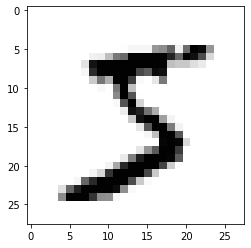

In [5]:
show_mnist(train_data[0, 1:])
print(f"Label: {train_data[0, 0]}")

손으로 쓴 숫자과 저장된 레이블을 확인할 수 있다.

### 1. 입력값 조정

- 0 ~ 255 사이의 값을 0.01 ~ 1.0 사이의 값으로 조정: $(\dfrac{x}{255} \times 0.99) + 0.01$
- 0.01부터 시작하는 이유는 입력값이 0이면 가중치 업데이트가 이뤄지지 않기 때문임

In [6]:
x_trains = (train_data[:, 1:] * 0.99 / 255) + 0.01

### 2. 출력값 조정

- Activation function으로 Sigmoide를 사용하고 있으므로 출력값이 0과 1인 경우가 없도록 조정
- One-Hot Encoding: Label이 i인 경우 i번째 Element를 0.99로, 나머지 Elements를 0.11로 Encoding
    - Label이 0이면: [0.99, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
    - Label이 5이면: [0.01, 0.01, 0.01, 0.01, 0.01, 0.99, 0.01, 0.01, 0.01, 0.01]

In [7]:
y_trains = np.zeros((train_data.shape[0], 10)) + 0.01

for i in range(train_data.shape[0]):
    label = train_data[i, 0]
    y_trains[i, label] = 0.99

## 2. Shallow Neural Network 학습 및 검증

### 1. Neural Network 객체 생성 및 초기화

- Input Data가 784개의 Elements(28 x 28)로 구성되므로 Input Node의 개수를 784로, 출력값은 One-Hot Encoding을 통해 10개의 Elements를 가진 배열이 나오도록 조정했으므로 Output Node의 개수는 10개로 고정해야 한다. Hidden Layer의 Node는 임의로 100개로 지정한다.
- Learning Rate는 0.3으로, Weight Matrix는 추가 실험을 위해 미리 생성하고 저장해둔다.

In [8]:
# number of input, hidden and output nodes
input_nodes = 784  # 28 x 28 images
hidden_nodes = 100
output_nodes = 10

# define learning rate
learning_rate = 0.3

# initialize weights
w_ih = np.random.rand(hidden_nodes, input_nodes) - 0.5
w_ho = np.random.rand(output_nodes, hidden_nodes) - 0.5

# create instance of neural network
nn = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, w_ih, w_ho)

### 2. Neural Network 학습

Training set 전체를 이용하여 학습한다.

In [9]:
for i in range(train_data.shape[0]):
    x_train = x_trains[i]
    y_train = y_trains[i]
    
    nn.train(x_train, y_train)

### 3. Neural Network 검증

검증 이전에 Test set을 Training set과 같이 조정한다.

In [10]:
x_tests = (test_data[:, 1:] * 0.99 / 255) + 0.01
y_tests = test_data[:, 0]

실제로 Network에 Test set을 입력한 후 계산된 예측값이 실제 레이블과 같은지 확인하고 정확도를 계산해본다.

In [11]:
score = 0
for i in range(x_tests.shape[0]):
    nn_output = nn.query(x_tests[i])
    nn_label = np.argmax(nn_output)
    
    real_label = y_tests[i]
    
    if nn_label == real_label:
        score += 1

print(f"Accuracy: {score} / {x_tests.shape[0]}, ({np.round(100 * score / x_tests.shape[0], 2)}%)")

Accuracy: 9166 / 10000, (91.66%)


Random한 요소가 존재하므로 코드를 실행시킬 때마다 정확도가 달라지겠지만, 단순한 구조의 신경망으로도 생각보다 높은 정확도(90% 초중반대)를 얻을 수 있다!

***

# Hyperparameter와 Performance

우리가 임의로 결정한 몇 가지 요소들이 있었다. 이러한 요소들은 하이퍼파라미터(Hyperparameter)라 하며, 경험이나 실험을 통해 값을 결정하게 된다. 아래 부분에서 하이퍼파라미터에 따라 Network의 성능이 어떻게 변화하는지 확인해본다.

## 1. 학습률

In [12]:
learning_rates = np.array(range(1, 10)) / 10
scores = []

for learning_rate in learning_rates:
    nn = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, w_ih, w_ho)
    
    for i in range(train_data.shape[0]):
        x_train = x_trains[i]
        y_train = y_trains[i]

        nn.train(x_train, y_train)
    
    score = 0
    for i in range(x_tests.shape[0]):
        nn_output = nn.query(x_tests[i])
        nn_label = np.argmax(nn_output)
        real_label = y_tests[i]

        if nn_label == real_label:
            score += 1
    
    scores.append(score)

accuracy = np.array(scores) / test_data.shape[0]

C:\Users\inseok\anaconda3\envs\isson\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp


Text(0, 0.5, 'Accuracy')

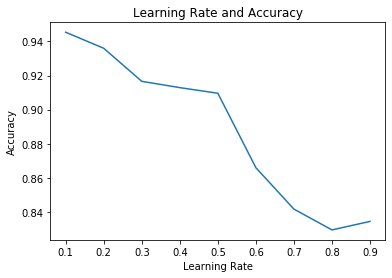

In [13]:
plt.plot(learning_rates, accuracy)

plt.title("Learning Rate and Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")

## 2. 주기(Epoch)

데이터셋 전체를 한 번씩 사용하여 학습을 수행하면 1주기(epoch)라 한다. 동일한 데이터셋을 반복하여 학습하는 것은 가중치의 값이 업데이트 되는 과정에서 더 많은 가능성을 제공하기 때문에 신경망의 성능을 개선할 수도 있다.

In [14]:
learning_rate = 0.3
epochs = np.array(range(1, 21))
scores = []

nn = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, w_ih, w_ho)

for epoch in epochs:
    for i in range(train_data.shape[0]):
        x_train = x_trains[i]
        y_train = y_trains[i]

        nn.train(x_train, y_train)
    
    score = 0
    for i in range(x_tests.shape[0]):
        nn_output = nn.query(x_tests[i])
        nn_label = np.argmax(nn_output)
        real_label = y_tests[i]

        if nn_label == real_label:
            score += 1
    
    scores.append(score)

accuracy = np.array(scores) / test_data.shape[0]

Text(0, 0.5, 'Accuracy')

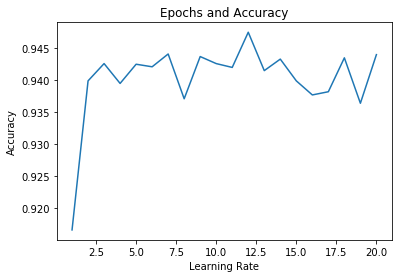

In [15]:
plt.plot(epochs, accuracy)

plt.title("Epochs and Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")

## 3. 학습 데이터의 순서

이 테스트는 책에서 다루지 않는 테스트이며 개인적인 궁금증으로 확인해본 것이다. 결과를 미리 적자면 학습 데이터의 순서는 Network에 영향을 **미친다.** 추가적인 검색을 통해서 확인해보니 성능에 아주 큰 영향은 미치지 않으나, **'학습 데이터가 Correlated되지 않도록 하라'**가 중론인 것 같다. (구글에서 'order of training data is important to machine learning?'라는 검색어를 입력하면 많은 질답을 확인할 수 있다.)

아래는 이를 확인하기 위해 `numpy.random.shuffle()`을 통해 Training set을 섞은 후 학습, 검증한 것이다.

In [16]:
nn = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, w_ih, w_ho)

pick_up_order = np.arange(train_data.shape[0])
np.random.shuffle(pick_up_order)

for i in pick_up_order:
    x_train = x_trains[i]
    y_train = y_trains[i]
    
    nn.train(x_train, y_train)

In [17]:
score = 0
for i in range(x_tests.shape[0]):
    nn_output = nn.query(x_tests[i])
    nn_label = np.argmax(nn_output)
    real_label = y_tests[i]
    
    if nn_label == real_label:
        score += 1

print(f"Accuracy: {score} / {x_tests.shape[0]}, ({np.round(100 * score / x_tests.shape[0], 2)}%)")

Accuracy: 9431 / 10000, (94.31%)


### 4. Hidden Layer의 Node 개수

Hidden Layer의 Node 개수를 변경하면 Weight Matrix의 크기 또한 변경해줘야 하므로 비중 행렬 초기화를 계속 해줘야 한다.

In [18]:
hidden_nodes_list = np.arange(50, 501, 50)
scores = []

for hidden_nodes in hidden_nodes_list:
    w_ih = np.random.rand(hidden_nodes, input_nodes) - 0.5
    w_ho = np.random.rand(output_nodes, hidden_nodes) - 0.5
    nn = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, w_ih, w_ho)

    for i in range(train_data.shape[0]):
        x_train = x_trains[i]
        y_train = y_trains[i]

        nn.train(x_train, y_train)
    
    score = 0
    for i in range(x_tests.shape[0]):
        nn_output = nn.query(x_tests[i])
        nn_label = np.argmax(nn_output)
        real_label = y_tests[i]

        if nn_label == real_label:
            score += 1
    
    scores.append(score)

accuracy = np.array(scores) / test_data.shape[0]

Text(0, 0.5, 'Accuracy')

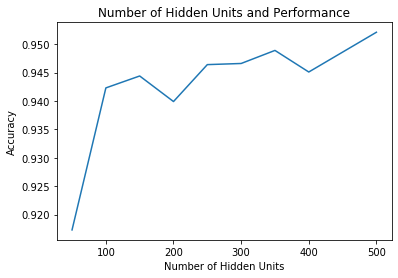

In [19]:
plt.plot(hidden_nodes_list, accuracy)

plt.title("Number of Hidden Units and Performance")
plt.xlabel("Number of Hidden Units")
plt.ylabel("Accuracy")

***

# 나만의 손글씨 데이터

본인이 Windows의 그림판을 이용하여 쓴 글씨를 Network가 분류할 수 있는지 확인해본다. 

Network로는 처음에 사용했던 구조를 사용한다.

In [20]:
# number of input, hidden and output nodes
input_nodes = 784  # 28 x 28 images
hidden_nodes = 100
output_nodes = 10

# define learning rate
learning_rate = 0.3

# initialize weights
w_ih = np.random.rand(hidden_nodes, input_nodes) - 0.5
w_ho = np.random.rand(output_nodes, hidden_nodes) - 0.5

# create instance of neural network
nn = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, w_ih, w_ho)

# training neural network
for i in range(train_data.shape[0]):
    x_train = x_trains[i]
    y_train = y_trains[i]
    
    nn.train(x_train, y_train)

`scipy` 라이브러리는 `scipy.misc.imread()` 함수를 1.0.0 버전 이후 Depreciate, 1.2.0 버전 이후 Remove 할 예정이므로 대신 `imageio` 라이브러리의 `imread()` 함수를 사용한다.

In [21]:
image = imageio.imread("data/my_handwriting/three.png")
image_array = image[:, :, 2].flatten()

일반적으로 0은 검은색을, 255는 흰색을 가리키지만 `MNIST` 데이터셋은 0을 흰색, 255를 검정으로 표기하고 있기에 이에 맞게 데이터를 가공해주어야 한다.

In [22]:
image_array = 255.0 - image_array

이후 입력값 조정을 해준다.

In [23]:
image_array = (image_array * 0.99 / 255) + 0.01

실제 그림과 Network가 예측한 숫자는 다음과 같다.

Network said this is 3


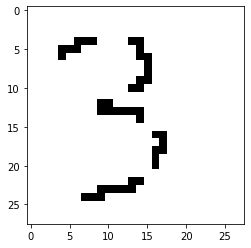

In [24]:
show_mnist(image_array.reshape((28, 28)))
print(f"Network said this is {np.argmax(nn.query(image_array))}")

내가 쓴 모든 글씨에 대해서 예측을 해보자.

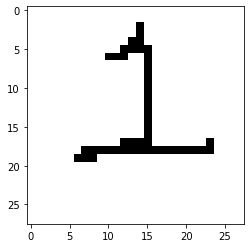

Network said this is 2


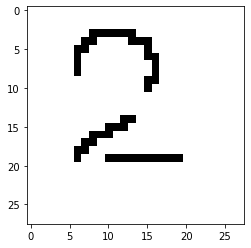

Network said this is 2


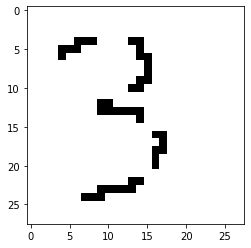

Network said this is 3


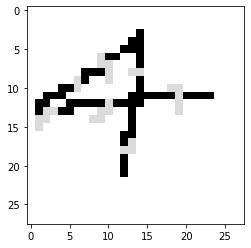

Network said this is 8


In [25]:
for file_name in ["one", "two", "three", "four"]:
    image = imageio.imread(f"data/my_handwriting/{file_name}.png")
    image_array = image[:, :, 2].flatten()
    
    image_array = 255.0 - image_array
    image_array = (image_array * 0.99 / 255) + 0.01
    
    show_mnist(image_array.reshape((28, 28)))
    plt.show()
    print(f"Network said this is {np.argmax(nn.query(image_array))}")

중간이 끊어진 2와 3은 잘 분류한 반면, 1과 4는 정확히 분류하지 못했다. 이는
1. 1의 경우 윗/아랫부분을 보면 2로 인식할만 한 것 같고,
2. 4의 경우 의도적으로 넣은 Noise 때문에 제대로된 인식을 하지 못한 것으로 보인다.

***

# 신경망의 마음속 들여다보기

우리가 작성한 신경망이 어떻게 답을 내는지를 확실하게는 알 수 없다. 하지만 학습 과정이 블랙 박스로 남아 우리의 지식이나 이해로 이어진다면 문제를 더 잘 이해할 수 있게 될 것이다! 가장 먼저 떠올릴 수 있는 방법은 가중치를 확인해보는 것이지만 유용한 정보를 얻기 힘들뿐더러, 하나 또는 상당수의 노드를 제거해도 신경망의 동작이 완전히 손상되는 것이 아니므로 단일 가중치를 일일히 확인해보는 것은 도움이 되지 않을 것이다.

대신 이미지를 넣으면 신경망이 레이블을 알려주는 과정을 역으로 해보는 것은 어떨까? 신경망이 생각하기에 특정 레이블로 확실하게 분류되기 위해서는 어떤 입력값을 넣어야하는지, 즉 어떤 그림이 입력되어야지 해당 레이블로 분류되는지를 알려줄 것이다. (이러한 과정을 **역질의(Backwards Query)**라 한다.)

아래는 책의 [Github page](https://github.com/makeyourownneuralnetwork/makeyourownneuralnetwork)에 작성되어 있는 역질의 관련 코드이다.

In [26]:
# Define logit function
def logit_function(x):
    return np.log(x / (1 - x))

# Backwards Query
def backquery(w_ih, w_ho, targets):
    # transpose the targets list to a vertical array
    final_outputs = np.array(targets, ndmin=2).T

    # calculate the signal into the final output layer
    final_inputs = logit_function(final_outputs)

    # calculate the signal out of the hidden layer
    hidden_outputs = w_ho.T @ final_inputs

    # scale them back to 0.01 to .99
    hidden_outputs -= np.min(hidden_outputs)
    hidden_outputs /= np.max(hidden_outputs)
    hidden_outputs *= 0.98
    hidden_outputs += 0.01

    # calculate the signal into the hidden layer
    hidden_inputs = logit_function(hidden_outputs)

    # calculate the signal out of the input layer
    inputs = w_ih.T @ hidden_inputs

    # scale them back to 0.01 to .99
    inputs -= np.min(inputs)
    inputs /= np.max(inputs)
    inputs *= 0.98
    inputs += 0.01

    return inputs

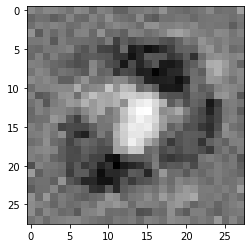

In [27]:
i = 0
targets = np.array([0.01] * 10)
targets[i] = 0.99
show_mnist(backquery(nn.w_ih, nn.w_ho, targets).reshape((28, 28)))

***

# 회전을 통해 새로운 학습 데이터 만들기

`MNIST` 데이터셋은 다양한 스타일의 필체가 포함되어 있으며, 다양한 형태의 숫자가 저장되어 있다. 다양한 형태의 데이터를 학습하는 것은 신경망에 있어서 매우 중요한 일이다. 그렇다면 현재의 예제들에 변형을 가해서 새로운 예제들을 만들면 학습에 도움이 되지 않을까? 아이디어를 확인 하기 위해 가장 기본적인 변형인 회전을 통해 새로운 데이터셋을 만들어서 학습 데이터로 사용하고 성과가 개선되었는지 확인해보자

변형은 `scipy.ndimage.interpolation.rotate()` 함수를 이용한다. 인자(arguments)는 다음과 같다.
- `input`: 입력값은 28 x 28 사이즈의 픽셀값이다.
- `angle`: 회전각
- `cval`: 이미지를 회전하면 원래의 이미지에는 존재하지 않다가 보여야 하는 부분이 있는데 그 부분을 `cval`에 입력된 값으로 채운다. 우리는 신경망의 입력값으로 0이 들어가는 것을 막기위해 0.01을 입력한다.
- `reshape`: 이미지를 찌그러뜨리는 것을 방지하고, 회전 후 이미지가 잘리지 않게 하려면 `False`를 인자로 전달한다.

In [31]:
rotate_image = lambda x, angle: scipy.ndimage.interpolation.rotate(x.reshape((28, 28)), angle, cval=0.01, reshape=False)

In [32]:
x_trains_pos = []
x_trains_neg = []
for x in x_trains:
    x_trains_pos.append(rotate_image(x, 10).reshape(28 * 28))
    x_trains_neg.append(rotate_image(x, -10).reshape(28 * 28))

x_trains_rotate = np.vstack([x_trains, x_trains_pos, x_trains_neg])
y_trains_rotate = np.tile(y_trains, (3, 1))

In [33]:
# number of input, hidden and output nodes
input_nodes = 784  # 28 x 28 images
hidden_nodes = 100
output_nodes = 10

# define learning rate
learning_rate = 0.3

# initialize weights
w_ih = np.random.rand(hidden_nodes, input_nodes) - 0.5
w_ho = np.random.rand(output_nodes, hidden_nodes) - 0.5

# create instance of neural network
nn = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, w_ih, w_ho)

# training neural network
for i in range(x_trains_rotate.shape[0]):
    x_train = x_trains_rotate[i]
    y_train = y_trains_rotate[i]
    
    nn.train(x_train, y_train)

In [34]:
score = 0
for i in range(x_tests.shape[0]):
    nn_output = nn.query(x_tests[i])
    nn_label = np.argmax(nn_output)
    
    real_label = y_tests[i]
    
    if nn_label == real_label:
        score += 1

print(f"Accuracy: {score} / {x_tests.shape[0]}, ({np.round(100 * score / x_tests.shape[0], 2)}%)")

Accuracy: 9305 / 10000, (93.05%)


***